# Treinamento de IA Stefanini
##Nome: João Vitor Rodrigues Baptista
## [Github](https://github.com/helpthx) 
##[LinkedIn](https://www.linkedin.com/in/jo%C3%A3o-vitor-rodrigues-baptista-4a3546149/) 

### Para as datas devem predizer qual são os montantes para os próximos pontos de entrada na validação e teste. E verificar em uma outra predição os pontos de melhores clientes. Lembrando que não quero a melhor predição e sim como irá ficar a arquitetura e as explicações.

#### Atributos:
Account No. - representa o número da conta envolvida na transação.\
Date - data da transação.\
Transaction Details - narrações de transação em extratos bancários.\
Cheque No. - indica o número do cheque.\
Value Date - Data de conclusão da transação.\
Withdrawal Amount - Indica o montante retirado.\
Deposit Amount - Indica o valor depositado.\
Balance Amount - saldo atual da conta.

### Jupyter do google Google Colab treinado usando GPU.
[Google Colab](https://colab.research.google.com/drive/1q8y010qy7E0bOYZ2Y7u9OL7YyEDTd8Im#scrollTo=AtcXAvvgH3Rf)


In [0]:
import numpy as np
import os
import sys
import time
import pandas as pd
import tensorflow as tf
import pickle
import logging
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,\
CSVLogger
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm._tqdm_notebook import tqdm_notebook
from tensorflow.python.client import device_lib
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
device_lib.list_local_devices()

Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18294541839262513554, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5382245465555520618
 physical_device_desc: "device: XLA_CPU device"]

### 1 - Fiz uma pequena pesquisa para verificar de onde poderia ter vindo os dados.

Encontrei que é um padrão de dados vindo de um tipo de servico bancario da India. Chamado HDFC Bank.

Referências: \
[1](https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944)\
[2](https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6)\
[3](https://medium.com/@_samkitjain/developing-a-bank-statement-analyser-7470bffbe5e2)


#### 2 - Lendo e Analizando os dados 

In [0]:
# Foi feita uma conversão de xlsx -> csv, apenas salvando o excel em csv
df_ge = pd.read_excel('bank.xlsx')
df_ge.tail()

,Account No,DATE,TRANSACTION DETAILS,CHQ.NO.,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,.
116196,409000362497',2019-03-05,TRF TO 1196428 Indiaforensic SE,NaN,2019-03-05,117934.30,NaN,-1.901902e+09,.
116197,409000362497',2019-03-05,FDRL/INTERNAL FUND TRANSFE,NaN,2019-03-05,NaN,300000.0,-1.901602e+09,.
116198,409000362497',2019-03-05,FDRL/INTERNAL FUND TRANSFE,NaN,2019-03-05,NaN,300000.0,-1.901302e+09,.
116199,409000362497',2019-03-05,IMPS 05-03-20194C,NaN,2019-03-05,109868.65,NaN,-1.901412e+09,.
116200,409000362497',2019-03-05,Sweep Trf To: 40900036427,NaN,2019-03-05,5000.00,NaN,-1.901417e+09,.


In [0]:
df_ge.head()

,Account No,DATE,TRANSACTION DETAILS,CHQ.NO.,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,.
0,409000611074',2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0,.
1,409000611074',2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0,.
2,409000611074',2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0,.
3,409000611074',2017-08-01,TRF FRM Indiaforensic SERVICES,NaN,2017-08-01,NaN,3000000.0,5500000.0,.
4,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,6000000.0,.


In [0]:
print(len(df_ge))

116201


In [0]:
print("Verificando a quantidade de valores NaN\n", df_ge.isna().sum())

Verificando a quantidade de valores NaN
 Account No                  0
DATE                        0
TRANSACTION DETAILS      2499
CHQ.NO.                115296
VALUE DATE                  0
WITHDRAWAL AMT          62652
DEPOSIT AMT             53549
BALANCE AMT                 0
.                           0
dtype: int64


In [0]:
df_ge.iloc[[21996]]

,Account No,DATE,TRANSACTION DETAILS,CHQ.NO.,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,.
21996,409000438620',2018-06-13,CR815910576719/RMCPL17224/0,NaN,2018-06-13,2000.0,NaN,-5.207105e+08,.


#### 3 - Tratando os NaN, tipos de dados e valores negaticos do dataframe 

In [0]:
# Verificando os tipos de dados
df_ge['BALANCE AMT'].dtypes

dtype('float64')

In [0]:
df_ge.describe()

,CHQ.NO.,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT
count,905.000000,5.354900e+04,6.265200e+04,1.162010e+05
mean,791614.503867,4.489190e+06,3.806586e+06,-1.404852e+09
std,151205.932910,1.084850e+07,8.683093e+06,5.348202e+08
min,1.000000,1.000000e-02,1.000000e-02,-2.045201e+09
25%,704231.000000,3.000000e+03,9.900000e+04,-1.690383e+09
50%,873812.000000,4.708300e+04,4.265000e+05,-1.661395e+09
75%,874167.000000,5.000000e+06,4.746411e+06,-1.236888e+09
max,874525.000000,4.594475e+08,5.448000e+08,8.500000e+06


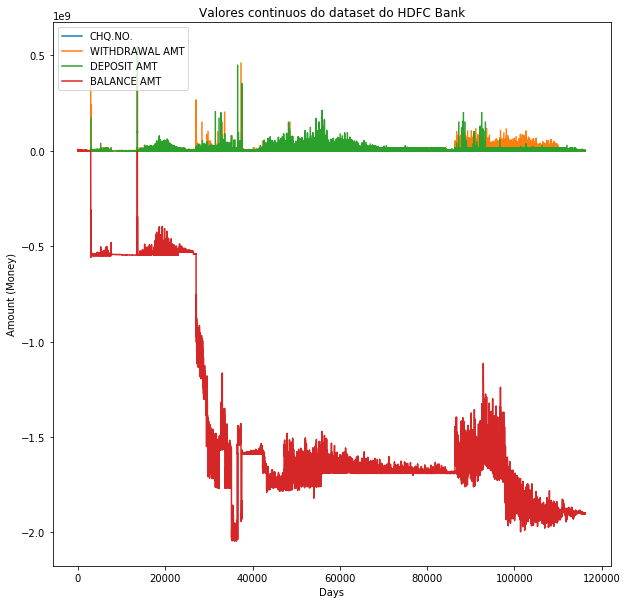

In [0]:
# Ploando os valores para avaliar o comportamento das colunas
plt.figure(figsize=(10,10))
plt.plot(df_ge['CHQ.NO.'])
plt.plot(df_ge['WITHDRAWAL AMT'])
plt.plot(df_ge['DEPOSIT AMT'])
plt.plot(df_ge['BALANCE AMT'])
plt.title('Valores continuos do dataset do HDFC Bank')
plt.ylabel('Amount (Money)')
plt.xlabel('Days')
plt.legend(['CHQ.NO.','WITHDRAWAL AMT','DEPOSIT AMT','BALANCE AMT'], 
           loc='upper left')
plt.show()

Parece que o WITHDRAWAL AMT e o DEPOSIT AMT não variam tanto ao longo dos dias, comparando os outras features.

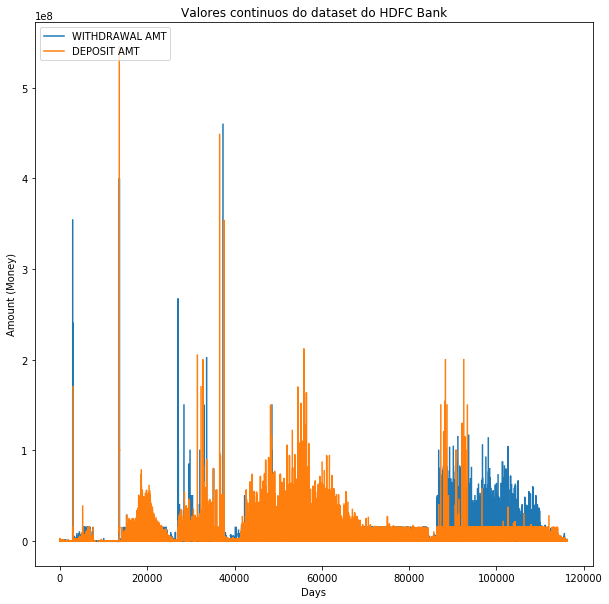

In [0]:
# Ploando os valores para avaliar o comportamento das colunas
plt.figure(figsize=(10,10))
plt.plot(df_ge['WITHDRAWAL AMT'])
plt.plot(df_ge['DEPOSIT AMT'])
plt.title('Valores continuos do dataset do HDFC Bank')
plt.ylabel('Amount (Money)')
plt.xlabel('Days')
plt.legend(['WITHDRAWAL AMT','DEPOSIT AMT'], loc='upper left')
plt.show()

### 4 - Normalizando os dados/ Partindo os dados em treino/teste
Como os dados não estão numa mesma escala é necessario fazer a normalização. Com a normalização é possivel convergir os dados para um local/global minino eficientemente.

In [0]:
df_ge=df_ge.fillna({'WITHDRAWAL AMT':0.0})
df_ge.head()

dataset = df_ge.filter(items =['WITHDRAWAL AMT'])
dataset.tail(5)

,WITHDRAWAL AMT
116196,117934.30
116197,0.00
116198,0.00
116199,109868.65
116200,5000.00


In [0]:
dataset.head(5)
len(dataset)

116201

In [0]:
dataset.describe()

,WITHDRAWAL AMT
count,1.162010e+05
mean,2.068757e+06
std,7.696881e+06
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,2.682500e+04
max,4.594475e+08


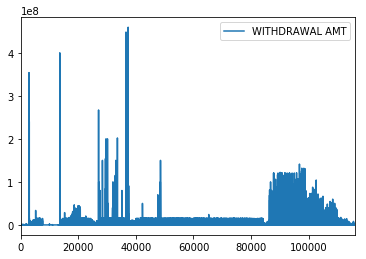

In [0]:
dataset.plot()

Para obter o valor do próximo dado, 60 registros anteriores são usados (2 meses). É necessário separar o dataset em treinamento e teste e, em seguida, separar cada pedaço (batch) dessas bases que serão usados nesses processos.

In [0]:
timesteps = 20

A normalização da base acelera o processo de treinamento, além de amenizar resultados insatisfatórios que podem ocorrer devido à grande variação nos valores durante o treinamento. Fazendo a normalização de 0 até 1

In [0]:
base = dataset.iloc[:][:].values # Conversão para float
normalizador = MinMaxScaler(feature_range=(0,1))
base_normalizada = normalizador.fit_transform(base)

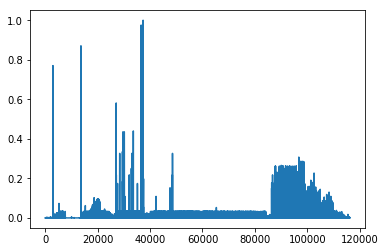

In [0]:
plt.plot(base_normalizada)

Seperando o dataset em batchs de treinamento e testes

In [0]:
X = base_normalizada[0:(len(base) - (len(base) % timesteps))] # Previsores

# Batches com tamanho = timesteps. Quantidade = (total de registros / timesteps)
X_batches = X.reshape(-1, timesteps, 1) 
Y = base_normalizada[1:(len(base) - (len(base) % timesteps)) + 1] # Valores reais
y_batches = Y.reshape(-1, timesteps, 1)

Criação e normalização das bases de testes

In [0]:
 # Últimos registros do banco. (len(banco) - timesteps) até o final dele
X_teste = base[-(timesteps + 1):]
X_teste = X_teste[:timesteps]
X_teste = normalizador.transform(X_teste)
X_teste = X_teste.reshape(-1, timesteps, 1) # Reshape para input do tensorflow

# Reparar que o y_teste não utiliza a base normalizada
y_teste = base[-(timesteps):] 
y_teste = y_teste.reshape(-1, timesteps, 1)

### Criando o modelo usando RNN do tensorflow

In [0]:
# Número de nós em cada camada
n_input = 1
n_hidden = 120
n_output = 1

# Variaveis de treinamento
epocas = 1000
n_display = epocas/10

tf.reset_default_graph() # Reseta o grafo atual

# Criação dos placeholders
x = tf.placeholder(tf.float32, [None, timesteps, n_input])
y = tf.placeholder(tf.float32, [None, timesteps, n_output])

In [0]:
# Função para criar uma célula LSTM
def inicializarUmaCelula():
    return tf.contrib.rnn.LSTMCell(num_units = n_hidden, 
                                   activation = tf.nn.relu)

In [0]:
# Função para criar n células LSTM
def inicializarVariasCelulas(n_celulas):
    celulas =  tf.nn.rnn_cell.MultiRNNCell(
        [inicializarUmaCelula() for i in range(n_celulas)])
    
    return tf.contrib.rnn.DropoutWrapper(celulas, input_keep_prob = 0.9) # Dropout

In [0]:
# Criação das células
celula = inicializarVariasCelulas(4) # 3 células
celula = tf.contrib.rnn.OutputProjectionWrapper(celula, output_size = 1)

W0718 23:16:08.787746 140068468361088 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0718 23:16:08.789522 140068468361088 deprecation.py:323] From <ipython-input-23-4e5dbf315af5>:3: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0718 23:16:08.795135 140068468361088 deprecation.py:323] From <ipython-input-24-210f144cac55>:3: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for 

Erros e métricas:
O otimizador mais adequado, depois de vários testes, foi o Adam A função de erro escolhida foi a MSE.

In [0]:
saida_rnn, _ = tf.nn.dynamic_rnn(celula, x, dtype = tf.float32)
erro = tf.losses.mean_squared_error(labels = y, predictions = saida_rnn)
otimizador = tf.train.AdamOptimizer(learning_rate = 0.001)
treinamento = otimizador.minimize(erro)

W0718 23:16:17.495331 140068468361088 deprecation.py:323] From <ipython-input-26-1b5ddac7763c>:1: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0718 23:16:18.625716 140068468361088 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0718 23:16:18.644070 140068468361088 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/rnn_cell_impl.py:961: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call init

In [0]:
# Inicializando variáveis globais
init = tf.global_variables_initializer()


Sessão de treinamento:

In [0]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoca in range(epocas+1):
        _, custo = sess.run([treinamento, erro], 
                            feed_dict = {x: X_batches, y: y_batches})
        if epoca % n_display == 0:
            print('Epoca:', epoca, '\terro (MSE):', custo)
    
    previsoes = sess.run(saida_rnn, feed_dict = {x: X_teste})


Epoca: 0 	erro (MSE): 0.00030107022


Repare que o erro é bem pequeno devido à normalização

### Resultados

Como essas variáveis estão no shape do tensorflow (3 dimensões), é necessário usar o método ravel para mudar suas dimensões.

In [0]:
y_teste_normal = np.ravel(y_teste)
print(y_teste.shape)
print(y_teste_normal.shape)

In [0]:
previsoes_normal = np.ravel(previsoes)
print(previsoes.shape)
print(previsoes_normal.shape)

As previsões devem ser desnormalizadas para comparar com y_teste

In [0]:
previsoes_normal = previsoes_normal.reshape(-1,1) 
previsoes_normal = normalizador.inverse_transform(previsoes_normal)
previsoes_normal = np.squeeze(previsoes_normal) 
# Para melhor visualização no print

A métrica Mean Absolute Error informa a diferença do valor real com o valor previsto, que é bom para verificar a acurácia do modelo.

In [0]:
mae = mean_absolute_error(y_teste_normal, previsoes_normal)

In [0]:
def exibirResultados():
    for i in range(len(previsoes_normal)):
        print('Previsão:', previsoes_normal[i], '\tValor real:', 
              y_teste_normal[i])
    
    print()
    print('Media do erro absoluto:', round(mae,4))

A função exibe um resumo dos resultados obtidos

In [0]:
exibirResultados()

### Visualização do gráfico

In [0]:
plt.plot(y_teste_normal, label = 'Valor real')
plt.plot(previsoes_normal, label = 'Previsões')
plt.legend()
plt.savefig(os.path.join('train_vis_BS__'+time.ctime()+'.png'))


A previsão tem um comportamento parecido com ao valor real, porem existem um descompaso muito grande entre os modulos em cada ponto, o que leva a um erro muito alto

## Para categorizar os clientes é necessario categorizar o tipo de transação que foi feita em Debit, Credit ou Default

In [0]:
df_ge.tail()

Transformando os valores em lista para fazer uma varredurar usando fors

In [0]:
rows = df_ge.values.tolist()
rows[116199][2]

In [0]:
# Vericando se n existem um balanco vazio na lista
# PS: Já verificado no dataframe do pandas

headers = []

for row in rows:
    if row[7] == 'nan':
        headers.append(rows)
    else:
        break

valid_transactions = []  

for row in rows:
    if row not in headers:
        valid_transactions.append(row)

In [0]:
len(valid_transactions)

In [0]:
# Iniciando os valores 
transactions = []                 # lista para guarda os valores da transação
d_i = 1        # da data
p_i = 2  # posição dos detalhes de transição

# iterate over all transactions
for v_t in valid_transactions:
    if v_t[d_i] is not None:
        transactions.append(v_t)
    
    else:
        transactions[-1][p_i] += v_t[p_i]
        
transactions[1]

In [0]:
# Posições na lista
w_i = 5  # posiçao do withdrawal
d_i = 6  # posição do deposito    
b_i = 7  # posição do balanco   
is_negative = False              
final_result = []                
# final_result = [][1]'withdrawal'
# final_result = [][0]'Type'
# 1.00 - debito
# -1.00 - credito
# 0 - default

# Faz interação sob todaas as transações para fazer a classificação dos valores 
for transaction in transactions:
    if transaction[w_i] > 00.00 and transaction[b_i] < 00.00:
        if is_negative:
            final_result[-1][8] = 1.00
        
        is_negative = True
        transaction[0] = 0
        final_result.append(transaction)

        continue
    
    elif is_negative:
        if transaction[d_i] == final_result[-1][5]:
            transaction[8] = 0
    
        else:
            final_result[-1][8] = 1.00
        
            if transaction[w_i] > 00.00 and transaction[b_i] < 00.00:
                is_negative = True
                transaction[8] = 0
                final_result.append(tran)
            
                continue
            
            # debito
            elif transaction[w_i] > 00.00:
                transaction[8] = 1.00
            
            # credito
            elif transaction[d_i] > 00.00:
                transaction[8] = -1.00
    
    # debito
    elif transaction[w_i] > 00.00:
        transaction[8] = 1.00
    
    # credito
    elif transaction[d_i] > 00.00:
        transaction[8] = -1.00
    
    is_negative = False
    final_result.append(transaction)

In [0]:
len(final_result)

In [0]:
df = pd.DataFrame(np.array(final_result), \
                  columns = list(
    ['AccountNo', 'DATE', 'TRANSACTION DETAILS',
     'CHQ.NO', 'VALUE DATE', 'WITHDRAWAL AMT', 
     'DEPOSIT AMT', 'BALANCE AMT', 'Type']))

In [0]:
df.head()

In [0]:
df.set_index(["AccountNo", "Type"]).count(level="Type")

In [0]:
df.groupby('AccountNo')['Type'].describe()

In [0]:
df.groupby('Type')['AccountNo'].describe()

In [0]:
df.pivot_table(index='Type',columns='AccountNo',aggfunc=sum)

A ideia que tive foi que classficando as transações eu poderia pegar o account id de cada cliente e mapeada pela quantidade de vezes que ele fez uma transação de creditos e de depositos para saber se o saldo dele é neutro ou se ele sempre faz mais depositos do que saques. Porem não conseguir pensar uma logica de agregação efetiva desses valores.